我们将使用pathlib处理路径（Python 3 标准库的一部分），并使用requests下载数据集。 我们只会在使用模块时才导入它们，因此您可以确切地看到每个位置上正在使用的模块。

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)


该数据集为 numpy 数组格式，并已使用pickle（一种用于序列化数据的 python 特定格式）存储。



In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")


每个图像为28 x 28，并存储为长度为784 = 28x28的扁平行。 让我们来看一个； 我们需要先将其重塑为 2d。


(50000, 784)


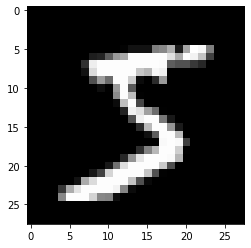

In [3]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)


PyTorch 使用torch.tensor而不是 numpy 数组，因此我们需要转换数据。



In [4]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


从零开始的神经网络（没有torch.nn）
首先，我们仅使用 PyTorch 张量操作创建模型。 我们假设您已经熟悉神经网络的基础知识。 （如果不是，则可以在 course.fast.ai 中学习它们）。

PyTorch 提供了创建随机或零填充张量的方法，我们将使用它们来为简单的线性模型创建权重和偏差。 这些只是常规张量，还有一个非常特殊的附加值：我们告诉 PyTorch 它们需要梯度。 这使 PyTorch 记录了在张量上完成的所有操作，因此它可以在反向传播时自动计算的梯度！

对于权重，我们在初始化之后设置requires_grad，因为我们不希望该步骤包含在梯度中。 （请注意，PyTorch 中的尾随_表示该操作是原地执行的。）

In [5]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)


由于 PyTorch 具有自动计算梯度的功能，我们可以将任何标准的 Python 函数（或可调用对象）用作模型！ 因此，我们只需编写一个普通矩阵乘法和广播加法即可创建一个简单的线性模型。 我们还需要激活函数，因此我们将编写并使用log_softmax。 请记住：尽管 PyTorch 提供了许多预写的损失函数，激活函数等，但是您可以使用纯 Python 轻松编写自己的函数。 PyTorch 甚至会自动为您的函数创建快速 GPU 或向量化的 CPU 代码。

In [6]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)


在上面，@代表点积运算。 我们将对一批数据（在本例中为 64 张图像）调用函数。 这是一个正向传播。 请注意，由于我们从随机权重开始，因此在这一阶段，我们的预测不会比随机预测更好。

In [7]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)


tensor([-2.2877, -2.6159, -2.1884, -2.7235, -2.9466, -2.3049, -2.0450, -2.1138,
        -2.0446, -2.1560], grad_fn=<SelectBackward0>) torch.Size([64, 10])


如您所见，preds张量不仅包含张量值，还包含梯度函数。 稍后我们将使用它进行反向传播。

让我们实现负对数可能性作为损失函数（同样，我们只能使用标准 Python）：

In [8]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll


让我们使用随机模型来检查损失，以便我们稍后查看反向传播后是否可以改善我们的损失。



In [9]:
yb = y_train[0:bs]
print(loss_func(preds, yb))


tensor(2.3814, grad_fn=<NegBackward0>)


我们还实现一个函数来计算模型的准确率。 对于每个预测，如果具有最大值的索引与目标值匹配，则该预测是正确的。



In [10]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()


In [11]:
print(accuracy(preds, yb))


tensor(0.1250)


现在，我们可以运行一个训练循环。 对于每次迭代，我们将：

选择一个小批量数据（大小为bs）
使用模型进行预测
计算损失
loss.backward()更新模型的梯度，在这种情况下为weights和bias。
现在，我们使用这些梯度来更新权重和偏差。 我们在torch.no_grad()上下文管理器中执行此操作，因为我们不希望在下一步的梯度计算中记录这些操作。 您可以在这里阅读有关 PyTorch 的 Autograd 如何记录操作的更多信息。

然后，将梯度设置为零，以便为下一个循环做好准备。 否则，我们的梯度会记录所有已发生操作的运行记录（即loss.backward()将梯度添加到已存储的内容中，而不是替换它们）。

In [12]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()


就是这样：我们完全从头开始创建并训练了一个最小的神经网络（在这种情况下，是逻辑回归，因为我们没有隐藏层）！

让我们检查损失和准确率，并将其与我们之前获得的进行比较。 我们希望损失会减少，准确率会增加，而且确实如此。

In [13]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))


tensor(0.0795, grad_fn=<NegBackward0>) tensor(1.)


使用torch.nn.functional
现在，我们将重构代码，使其执行与以前相同的操作，只是我们将开始利用 PyTorch 的nn类使其更加简洁和灵活。 从这里开始的每一步，应该使我们的代码占一个或多个特点：更简洁、更易理解、和/或更灵活。

第一步也是最简单的步骤，就是用torch.nn.functional（通常按照惯例将其导入到名称空间F中）替换我们的手写激活和损失函数，从而缩短代码长度。 该模块包含torch.nn库中的所有函数（而该库的其他部分包含类）。 除了广泛的损失和激活函数外，您还会在这里找到一些方便的函数来创建神经网络，例如池化函数。 （还有一些用于进行卷积，线性层等的函数，但是正如我们将看到的那样，通常可以使用库的其他部分来更好地处理这些函数。）

如果您使用的是负对数似然损失和对数 softmax 激活，那么 Pytorch 会提供结合了两者的单一函数F.cross_entropy。 因此，我们甚至可以从模型中删除激活函数。

In [14]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias


In [15]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))


tensor(0.0795, grad_fn=<NllLossBackward0>) tensor(1.)


使用nn.Module重构

接下来，我们将使用nn.Module和nn.Parameter进行更清晰，更简洁的训练循环。 我们将nn.Module子类化（它本身是一个类并且能够跟踪状态）。 在这种情况下，我们要创建一个类，该类包含前进步骤的权重，偏置和方法。 nn.Module具有许多我们将要使用的属性和方法（例如.parameters()和.zero_grad()）。

注意

nn.Module（大写M）是 PyTorch 的特定概念，并且是我们将经常使用的一类。 不要将nn.Module与模块（小写m）的 Python 概念混淆，该模块是可以导入的 Python 代码文件。

In [16]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias


由于我们现在使用的是对象而不是仅使用函数，因此我们首先必须实例化模型：



In [17]:
model = Mnist_Logistic()


现在我们可以像以前一样计算损失。 请注意，nn.Module对象的使用就好像它们是函数一样（即，它们是可调用的），但是在后台 Pytorch 会自动调用我们的forward方法。

In [18]:
print(loss_func(model(xb), yb))


tensor(2.5762, grad_fn=<NllLossBackward0>)


以前，在我们的训练循环中，我们必须按名称更新每个参数的值，并手动将每个参数的梯度分别归零，如下所示：

In [19]:
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()


现在我们可以利用model.parameters()和model.zero_grad()（它们都由 PyTorch 为nn.Module定义）来使这些步骤更简洁，并且更不会出现忘记某些参数的错误，尤其是当我们有一个更复杂的模型的时候：

In [22]:
with torch.no_grad():
    for p in model.parameters(): p = p - p.grad * lr
    model.zero_grad()


TypeError: ignored

我们将把小的训练循环包装在fit函数中，以便稍后再运行。



In [23]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()


In [24]:
print(loss_func(model(xb), yb))


tensor(0.0830, grad_fn=<NllLossBackward0>)


使用nn.Linear重构
我们继续重构我们的代码。 代替手动定义和初始化self.weights和self.bias并计算xb  @ self.weights + self.bias，我们将对线性层使用 Pytorch 类nn.Linear，这将为我们完成所有工作。 Pytorch 具有许多类型的预定义层，可以大大简化我们的代码，并且通常也可以使其速度更快。

In [25]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)


我们以与以前相同的方式实例化模型并计算损失：

In [26]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))


tensor(2.2839, grad_fn=<NllLossBackward0>)


我们仍然可以使用与以前相同的fit方法。

In [27]:
fit()

print(loss_func(model(xb), yb))


tensor(0.0807, grad_fn=<NllLossBackward0>)


使用optim重构
Pytorch 还提供了一个包含各种优化算法的包torch.optim。 我们可以使用优化器中的step方法采取向前的步骤，而不是手动更新每个参数。

这将使我们替换之前的手动编码优化步骤：

In [28]:
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()


而是只使用：



In [ ]:
opt.step()
opt.zero_grad()


我们将定义一个小函数来创建模型和优化器，以便将来重用。



In [31]:
from torch import optim

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))


tensor(2.3074, grad_fn=<NllLossBackward0>)
tensor(0.0814, grad_fn=<NllLossBackward0>)


使用Dataset重构
PyTorch 有一个抽象的Dataset类。 数据集可以是具有__len__函数（由 Python 的标准len函数调用）和具有__getitem__函数作为对其进行索引的一种方法。 本教程演示了一个不错的示例，该示例创建一个自定义FacialLandmarkDataset类作为Dataset的子类。

PyTorch 的TensorDataset是一个数据集包装张量。 通过定义索引的长度和方式，这也为我们提供了沿张量的第一维进行迭代，索引和切片的方法。 这将使我们在训练的同一行中更容易访问自变量和因变量。

x_train和y_train都可以合并为一个TensorDataset，这将更易于迭代和切片。



In [32]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)


以前，我们不得不分别遍历x和y值的小批量：


In [ ]:
xb = x_train[start_i:end_i]
yb = y_train[start_i:end_i]


现在，我们可以一起执行以下两个步骤：


In [33]:
xb,yb = train_ds[i*bs : i*bs+bs]

model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))


tensor(0.0812, grad_fn=<NllLossBackward0>)


使用DataLoader重构
Pytorch 的DataLoader负责批量管理。 您可以从任何Dataset创建一个DataLoader。 DataLoader使迭代迭代变得更加容易。 不必使用train_ds[i*bs : i*bs+bs]，DataLoader会自动为我们提供每个小批量。

In [34]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)


以前，我们的循环遍历如下批量(xb, yb)：



In [ ]:
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    pred = model(xb)


现在，我们的循环更加简洁了，因为(xb, yb)是从数据加载器自动加载的：



In [35]:
for xb,yb in train_dl:
    pred = model(xb)

model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))


tensor(0.0801, grad_fn=<NllLossBackward0>)


得益于 Pytorch 的nn.Module，nn.Parameter，Dataset和DataLoader，我们的训练循环现在变得更小，更容易理解。 现在，让我们尝试添加在实践中创建有效模型所需的基本功能。

添加验证
在第 1 节中，我们只是试图建立一个合理的训练循环以用于我们的训练数据。 实际上，您也应该始终具有验证集，以便识别您是否过拟合。

对训练数据进行打乱对于防止批量与过拟合之间的相关性很重要。 另一方面，无论我们是否打乱验证集，验证损失都是相同的。 由于打乱需要花费更多时间，因此打乱验证数据没有任何意义。

我们将验证集的批量大小设为训练集的两倍。 这是因为验证集不需要反向传播，因此占用的内存更少（不需要存储梯度）。 我们利用这一优势来使用更大的批量，并更快地计算损失。

In [36]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)


我们将在每个周期结束时计算并打印验证损失。

（请注意，我们总是在训练之前调用model.train()，并在推理之前调用model.eval()，因为诸如nn.BatchNorm2d和nn.Dropout之类的层会使用它们，以确保这些不同阶段的行为正确。）

In [37]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))


0 tensor(0.2967)
1 tensor(0.4925)


创建fit()和get_data()

现在，我们将自己进行一些重构。 由于我们经历了两次相似的过程来计算训练集和验证集的损失，因此我们将其设为自己的函数loss_batch，该函数可计算一批损失。

我们将优化器传入训练集中，然后使用它执行反向传播。 对于验证集，我们没有通过优化程序，因此该方法不会执行反向传播。

In [38]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)
 

fit运行必要的操作来训练我们的模型，并计算每个周期的训练和验证损失。



In [39]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)


get_data返回训练和验证集的数据加载器。



In [40]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )


现在，我们获取数据加载器和拟合模型的整个过程可以在 3 行代码中运行：



In [41]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)


0 0.3444567593574524
1 0.30786916316747664


您可以使用这些基本的 3 行代码来训练各种各样的模型。 让我们看看是否可以使用它们来训练卷积神经网络（CNN）！

切换到 CNN
现在，我们将构建具有三个卷积层的神经网络。 由于上一节中的任何功能都不假设任何有关模型形式的信息，因此我们将能够使用它们来训练 CNN，而无需进行任何修改。

我们将使用 Pytorch 的预定义Conv2d类作为我们的卷积层。 我们定义了具有 3 个卷积层的 CNN。 每个卷积后跟一个 ReLU。 最后，我们执行平均池化。 （请注意，view是 numpy 的reshape的 PyTorch 版本）

In [43]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1


动量是随机梯度下降的一种变体，它也考虑了以前的更新，通常可以加快训练速度。



In [44]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)


0 0.35270360226631164
1 0.24903705486059188


nn.Sequential
torch.nn还有另一个方便的类，可以用来简化我们的代码：Sequential。 Sequential对象以顺序方式运行其中包含的每个模块。 这是编写神经网络的一种简单方法。

为了利用这一点，我们需要能够从给定的函数轻松定义自定义层。 例如，PyTorch 没有视层，我们需要为我们的网络创建一个层。 Lambda将创建一个层，然后在使用Sequential定义网络时可以使用该层。

In [46]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

def preprocess(x):
    return x.view(-1, 1, 28, 28)


用Sequential创建的模型很简单：



In [47]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)


0 0.4310701187372208
1 0.31494008758068087


包装DataLoader

Our CNN is fairly concise, but it only works with MNIST, because:

假设输入为28 * 28长向量
假设 CNN 的最终网格尺寸为4 * 4（因为这是平均值
我们使用的合并核大小）

让我们摆脱这两个假设，因此我们的模型适用于任何 2d 单通道图像。 首先，我们可以删除初始的 Lambda 层，但将数据预处理移至生成器中：

In [48]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)


接下来，我们可以将nn.AvgPool2d替换为nn.AdaptiveAvgPool2d，这使我们能够定义所需的输出张量的大小，而不是所需的输入张量的大小。 结果，我们的模型将适用于任何大小的输入。



In [49]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)


In [50]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)


0 0.3571149311065674
1 0.27743021072149276


使用您的 GPU
如果您足够幸运地能够使用具有 CUDA 功能的 GPU（可以从大多数云提供商处以每小时 0.50 美元的价格租用一个），则可以使用它来加速代码。 首先检查您的 GPU 是否在 Pytorch 中正常工作：

In [51]:
print(torch.cuda.is_available())


True


In [52]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


In [53]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)


In [54]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)


In [55]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)


0 0.18295787568092345
1 0.17820702099204064


总结
现在，我们有了一个通用的数据管道和训练循环，您可以将其用于使用 Pytorch 训练许多类型的模型。 要了解现在可以轻松进行模型训练，请查看mnist_sample示例笔记本。

当然，您需要添加很多内容，例如数据扩充，超参数调整，监控训练，迁移学习等。 这些功能可在 fastai 库中使用，该库是使用本教程中所示的相同设计方法开发的，为希望进一步推广其模型的从业人员提供了自然的下一步。

我们承诺在本教程开始时将通过示例分别说明torch.nn，torch.optim，Dataset和DataLoader。 因此，让我们总结一下我们所看到的：

- torch.nn
  - Module：创建一个行为类似于函数的可调用对象，但也可以包含状态（例如神经网络层权重）。 它知道其中包含的 Parameter ，并且可以将其所有坡度归零，遍历它们以进行权重更新等。
  - Parameter：张量的包装器，用于告知 Module 具有在反向传播期间需要更新的权重。 仅更新具有require_grad属性集的张量
  - functional：一个模块（通常按照惯例导入到 F 名称空间中），其中包含激活函数，损失函数等。 以及卷积和线性层等层的无状态版本。
- torch.optim：包含诸如 SGD 的优化程序，这些优化程序在后退步骤
- Dataset 中更新 Parameter 的权重。 具有 __len__ 和 __getitem__ 的对象，包括 Pytorch 提供的类，例如 TensorDataset
- DataLoader：获取任何 Dataset 并创建一个迭代器，该迭代器返回批量数据。